In [1]:
import time
import numpy as np
import pandas as pd

import galsim #install with conda install -c conda_forge galsim

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as norm
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline #This allows one to build different steps together
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm import tqdm 

import target_predicting_RF_function_and_feature_ranking_TNGSIM as functions
import RF_target_predicting_and_learning_curves_functions_TNGSIM as tp_lc_functions

import os
os.mkdir('TNG-SIM_images/v22_Disks_SVR')

In [3]:
# Using the 0D TNG100 SIM data at z=0 (version 5 of the dataset in this notebook, 
# for further explanation see Notebook v3 updated and v14)

df_0D = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v5_TNG-SIM_0D_Dataset.csv')
df_raw = pd.read_csv('TNG-SIM_images/v3_initial_analysis/v4_TNG-SIM_Raw_Dataset.csv')
print("df_0D.shape", df_0D.shape)
print("df_raw.shape", df_raw.shape)

df_0D.shape (21598, 16)
df_raw.shape (21598, 19)


### <font color='purple'> <a id =10> </a> <br> Take Log10 of all features and target, both 0D & raw

In [4]:
def log_df(df_init):
    
    df = df_init.copy()
    for feature in df.columns.to_list():
        if 'log' not in feature:
            df.loc[:, feature + '_log']=df.loc[:,feature].apply(lambda x: np.log10(x + 1.e-8))
            df.drop(columns = [feature], inplace = True)
#             print(df.loc[:, feature])
        else:continue
        
    return df

In [5]:
df_raw_log = log_df(df_raw)

In [6]:
df_raw_log.head(2)

,SubhaloBHMass_log,SubhaloBHMdot_log,SubhaloGasMetallicity_log,SubhaloSFRinRad_log,SubhaloStarMetallicity_log,SubhaloVelDisp_log,SubhaloVmax_log,SubhaloVmaxRad_log,SubhaloRgas_log,SubhaloRstar_log,SubhaloMgas_log,SubhaloMstar_log,GroupNsubs_log,Group_M_TopHat200_log,Group_R_TopHat200_log,SubhaloMHI_log,SubhaloMH2_log,Group_V_TopHat200_log,GroupSpin_dmo_log
0,9.998109,-3.400095,-2.112483,-0.708133,-1.543295,2.780947,2.999733,2.668073,2.949910,1.828096,13.092064,12.497443,4.235150,14.646987,3.292134,10.061858,10.043734,2.994161,-1.769689
1,9.898275,-4.012083,-2.359742,0.219496,-1.679031,2.774496,2.981978,3.134860,2.988572,2.098578,13.610459,12.316876,4.150971,14.687475,3.305635,9.899765,9.955786,3.007654,-1.893303


In [7]:
df_raw_log.shape

(21598, 19)

In [8]:
df_raw.shape

(21598, 19)

In [9]:
df_0D_log = log_df(df_0D)

In [10]:
df_0D_log.shape

(21598, 16)

In [11]:
df_0D.shape

(21598, 16)

### <font color='purple'> <a id =10> </a> <br> Define disks dataset as explained in Notebook v21

In [13]:
df_mstarcut_raw_log = df_raw_log[(df_raw_log.SubhaloMstar_log>=8.3) & (df_raw_log.SubhaloMstar_log<=11)]
print('df_mstarcut_raw_log.shape;', df_mstarcut_raw_log.shape)
df_sfrcut_raw_log = df_mstarcut_raw_log[(df_mstarcut_raw_log.SubhaloSFRinRad_log>=-1.2) & 
                                          (df_mstarcut_raw_log.SubhaloSFRinRad_log<=1.0)]
print('f_sfrcut_raw_log.shape:', df_sfrcut_raw_log.shape)

df_mstarcut_raw_log.shape; (21308, 19)
f_sfrcut_raw_log.shape: (13879, 19)


In [14]:
# Using the slope above, point A[8.3, -1.2] and point B[11.0, 1.0], define the slope function below
# and then filter to only use the points in the upper part of the slope
slope = 0.82
intercept = -8.02

def calculate_yhat(x):
    
    yhat = slope * x + intercept 
    
    return yhat

In [15]:
y_hat = calculate_yhat(df_sfrcut_raw_log.SubhaloMstar_log)

In [16]:
df_sfrcut_raw_log.SubhaloSFRinRad_log[df_sfrcut_raw_log.SubhaloMstar_log >= y_hat]

128     -0.609494
157      0.559392
200     -0.268196
205     -0.306691
231     -0.072653
           ...   
21080   -0.957526
21107   -0.952930
21132   -0.930914
21136   -1.090885
21207   -0.728020
Name: SubhaloSFRinRad_log, Length: 13879, dtype: float64

In [17]:
# Define disk galaxies as the points above the SFR-Mstar slope 
df_disks = df_sfrcut_raw_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat]
df_disks.shape

(3215, 19)

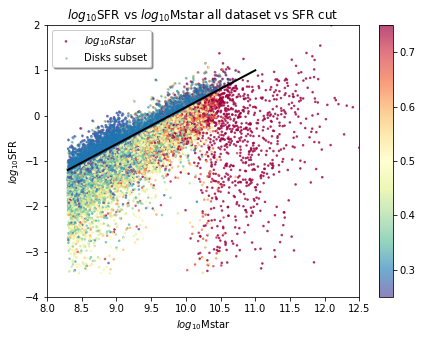

In [28]:
# Plot of log SFR vs log Mstar to see the trend and define disk galaxies

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR1 = ax.scatter(df_raw_log.SubhaloMstar_log, df_raw_log.SubhaloSFRinRad_log,
            c = df_raw_log.SubhaloRstar_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}Rstar$', vmin=0.25, vmax=0.75)
fig_SR = ax.scatter(df_sfrcut_raw_log.SubhaloMstar_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat], df_sfrcut_raw_log.SubhaloSFRinRad_log[df_sfrcut_raw_log.SubhaloSFRinRad_log >= y_hat],
            #c = df_sfrcut_raw_log2.SubhaloRstar_log, 
            s=10, marker='.', alpha=0.3,label= r'Disks subset') #, vmin=0.25, vmax=0.75)

# ax.text(-0.15, 1.35, r'$R^{2}$ score=blabla', size=12)
ax.axis([8.0,12.5, -4, 2.0])
ax.plot([8.3, 11.0], [-1.2, 1.0], color = 'black', linewidth = 2)
ax.set_title(r'$log_{10}$SFR vs $log_{10}$Mstar all dataset vs SFR cut')
ax.set_xlabel(r'$log_{10}$Mstar')
ax.legend(loc = 'upper left', shadow=True)
ax.set_ylabel(r'$log_{10}$SFR')
fig_complete.colorbar(fig_SR1, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/SFR_vs_Mstar_colorRstar_Disks.jpeg', dpi=500)
plt.show()

### <font color='purple'> <a id =10> </a> <br> Disks Raw Dataset: SVR

In [19]:
df_disks.columns.to_list()

['SubhaloBHMass_log',
 'SubhaloBHMdot_log',
 'SubhaloGasMetallicity_log',
 'SubhaloSFRinRad_log',
 'SubhaloStarMetallicity_log',
 'SubhaloVelDisp_log',
 'SubhaloVmax_log',
 'SubhaloVmaxRad_log',
 'SubhaloRgas_log',
 'SubhaloRstar_log',
 'SubhaloMgas_log',
 'SubhaloMstar_log',
 'GroupNsubs_log',
 'Group_M_TopHat200_log',
 'Group_R_TopHat200_log',
 'SubhaloMHI_log',
 'SubhaloMH2_log',
 'Group_V_TopHat200_log',
 'GroupSpin_dmo_log']

In [20]:
X_all = df_disks.drop(columns=['SubhaloRstar_log'])
 

y_all = df_disks.loc[:,'SubhaloRstar_log']

In [21]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2], 
             }


model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 2, n_jobs = -1, return_train_score=True)

model_all.fit(X_all, y_all)

print('Best params, best score:', "{:.4f}".format(model_all.best_score_), \
      model_all.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM Raw SVR Dataset: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best params, best score: 0.8949 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw SVR Dataset: 18.573 seconds


Fitting 3 folds for each of 75 candidates, totalling 225 fits

Best params, best score: 0.8949 {'svr__C': 10.0, 'svr__epsilon': 0.05, 'svr__gamma': 0.01, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw SVR Dataset: 18.573 seconds


In [23]:
start_time = time.time()

best_SVR_all=model_all.best_estimator_

best_SVR_trainscore_all=model_all.cv_results_['mean_train_score'][model_all.best_index_]

scores_SVR_all = cross_val_score(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 53 seconds ~ 1min to run this patch of code

Elapsed time to compute this patch of code: 0.991 seconds


In [24]:
start_time = time.time()

y_pred_SVR_all = cross_val_predict(best_SVR_all, X_all, y_all, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Disks Raw Dataset: {elapsed_time:.3f} seconds")

# It took 54 seconds ~ 1min to run this patch of code

Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Disks Raw Dataset: 0.979 seconds


In [29]:
y_pred_SVR_df_all = pd.DataFrame({'y_pred_SVR SIM Raw': y_pred_SVR_all})

# y_pred_SVR_df_all.to_csv('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_y_pred_SVR_predicted_sizes.csv', index=False)

# y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_y_pred_SVR_predicted_sizes.csv')

In [30]:
best_SVR_trainscore_all

0.9139342092983389

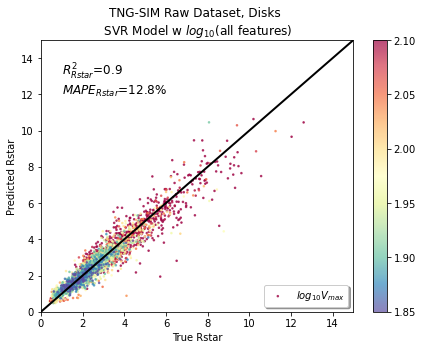

In [38]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_disks.SubhaloRstar_log), 10**(y_pred_SVR_all),
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
ax.text(1.0, 12, r'$R^{2}_{Rstar}$=0.9' + '\n' + r'$MAPE_{Rstar}$=12.8$\%$ ', size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0, 30], [0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'SVR Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_SVR_size_pred_colorVmaxVvir_2.jpeg', dpi=500)
plt.show()

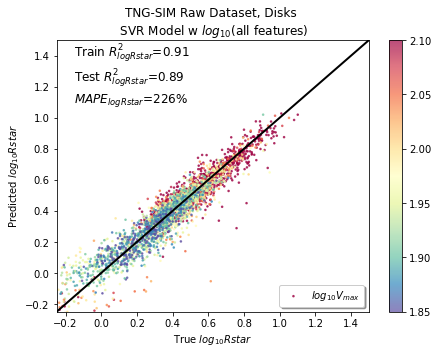

In [41]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks.SubhaloRstar_log, y_pred_SVR_all,
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.91' + '\n' + r'Test $R^{2}_{logRstar}$=0.89' + '\n' + r'$MAPE_{logRstar}$=226$\%$ ', size=12)
ax.axis([-0.25,1.5, -0.25,1.5])
ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'SVR Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True $log_{10}Rstar$')
ax.set_ylabel(r'Predicted $log_{10}Rstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_SVR_size_pred_colorlogVmaxVvir_1.jpeg', dpi=500)
plt.show()

### Other metrics

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

##### <font color='darkgreen'> <a id =10> </a> <br>log(Rstar) metrics

In [33]:
print('MSE:', mean_squared_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('sqrtMSE:', np.sqrt(mean_squared_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw'])))
print('MAE:', mean_absolute_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('MAPE_logRstar:', mean_absolute_percentage_error(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))     
print('R2_logRstar:', r2_score(df_disks.loc[:, 'SubhaloRstar_log'], y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))

MSE: 0.005661990148407247
sqrtMSE: 0.07524619690328041
MAE: 0.05522361154828955
MAPE_logRstar: 2.2562764022101303
R2_logRstar: 0.8967481101778236


In [40]:
2.256*100


225.59999999999997

##### <font color='darkgreen'> <a id =10> </a> <br> Rstar metrics

In [34]:
print('MSE:', mean_squared_error(10**df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('sqrtMSE:', np.sqrt(mean_squared_error(10**df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw'])))
print('MAE:', mean_absolute_error(10**df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))
print('MAPE_Rstar:', mean_absolute_percentage_error(10**df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))     
print('R2_Rstar:', r2_score(10**df_disks.loc[:, 'SubhaloRstar_log'], 10**y_pred_SVR_df_all.loc[:,'y_pred_SVR SIM Raw']))

MSE: 0.23072427335669818
sqrtMSE: 0.48033766597748523
MAE: 0.33095981840798194
MAPE_Rstar: 0.12832427248504474
R2_Rstar: 0.9001156870856364


### <font color='purple'> <a id =3> </a> <br> SVR Learning Curve

In [42]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'r2', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    
    fig, ax = plt.subplots(figsize=(7, 5))
#     plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("# of training examples",fontsize = 14)
 
    ax.set_ylabel(r"$R^{2}$ score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    ax.legend(loc="best",fontsize = 12)
    return fig

Elapsed time to run SVR Learning Curves on the disks dataset: 1.373 seconds


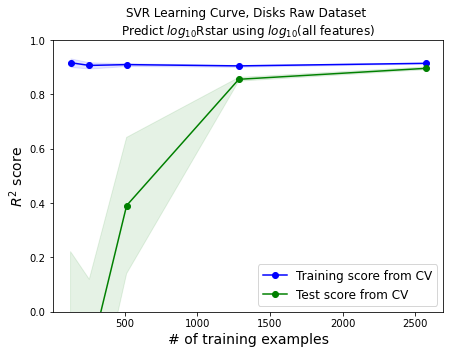

In [43]:
# this code takes ~2.5min to run on the whole dataset with ~22,000 galaxies
start_time = time.time()

lc_all = plot_learning_curve(best_SVR_all, 'SVR Learning Curve, Disks Raw Dataset \n'+r'Predict $log_{10}$Rstar using $log_{10}$(all features)', X_all, y_all, ylim=(0.0, 1.0), train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), scoring='r2', cv = KFold(n_splits=5, shuffle=True))
# plt.savefig('LC_SVR_Complete_Dataset.jpeg', dpi=500)
elapsed_time = time.time() - start_time

print(f"Elapsed time to run SVR Learning Curves on the disks dataset: {elapsed_time:.3f} seconds")

In [44]:
# lc_all.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_SVR_Learning_Curve.jpeg', dpi=500)

### <font color='purple'> <a id =3> </a> <br> SVR Add-on Feature Ranking
   

In [167]:


def run_svr_search_pipeline(X, y):
    
    
    piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

    piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

    parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2], 
                 }


    model_all = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True, random_state=2024), \
                     verbose = 0, n_jobs = -1, return_train_score=True)

    model_all.fit(X, y)
    
    scores_lim = pd.DataFrame(model_all.cv_results_)

    scores_lim = scores_lim[['params','mean_test_score','std_test_score','mean_train_score', 'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)
    
    return scores_lim
#     return scores_lim['mean_test_score']

In [168]:
def calculate_r_score( X , y ,column_names):
    x_new = X[list(column_names)]
    # print(column_names)
    r_square = run_svr_search_pipeline(x_new, y)['mean_test_score']
    
    return r_square.max()


def print_results(max_col_names, max_col_rscores):
    k= 1
    for i, j in zip(max_col_names, max_col_rscores):
        print("\t", k, i,j)
        k +=1

In [169]:
def calc_ith_iteration( X, y, max_col_names, max_col_rscores, orj_column_names, i):
    r_score_dict = {}
    for column_names in tqdm(orj_column_names): # orj_column_names = original column names
        # count += 1
        # print(count, max_col_names , column_names)
        feature_list = max_col_names + [column_names]
        r_score = calculate_r_score(X , y ,feature_list)
        r_score_dict[column_names] = r_score
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))
    # print("asdfasd", max_col_names[len(max_col_names) - 1])
    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    return max_col_names, max_col_rscores, orj_column_names, r_score_dict

  6%|██▎                                      | 1/18 [04:47<1:21:35, 287.96s/it]

	 1 SubhaloMH2_log 0.45545596118674103



 11%|████▌                                    | 2/18 [26:47<3:58:33, 894.62s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943



 17%|██████▋                                 | 3/18 [45:54<4:12:29, 1009.96s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738



 22%|█████████                                | 4/18 [59:51<3:39:42, 941.60s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354



 28%|██████████▊                            | 5/18 [1:13:58<3:16:38, 907.61s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354
	 5 SubhaloGasMetallicity_log 0.8607383576525747



 33%|█████████████                          | 6/18 [1:23:19<2:37:58, 789.86s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354
	 5 SubhaloGasMetallicity_log 0.8607383576525747
	 6 SubhaloMHI_log 0.8778516442251129



 39%|███████████████▏                       | 7/18 [1:31:28<2:06:44, 691.36s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354
	 5 SubhaloGasMetallicity_log 0.8607383576525747
	 6 SubhaloMHI_log 0.8778516442251129
	 7 SubhaloVmaxRad_log 0.8836859044345285



 44%|█████████████████▎                     | 8/18 [1:39:25<1:43:51, 623.11s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354
	 5 SubhaloGasMetallicity_log 0.8607383576525747
	 6 SubhaloMHI_log 0.8778516442251129
	 7 SubhaloVmaxRad_log 0.8836859044345285
	 8 SubhaloVelDisp_log 0.8936541912329657



 50%|███████████████████▌                   | 9/18 [1:46:01<1:22:50, 552.27s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354
	 5 SubhaloGasMetallicity_log 0.8607383576525747
	 6 SubhaloMHI_log 0.8778516442251129
	 7 SubhaloVmaxRad_log 0.8836859044345285
	 8 SubhaloVelDisp_log 0.8936541912329657
	 9 Group_R_TopHat200_log 0.899164166767006



 50%|███████████████████▌                   | 9/18 [1:51:43<1:51:43, 744.80s/it]

	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354
	 5 SubhaloGasMetallicity_log 0.8607383576525747
	 6 SubhaloMHI_log 0.8778516442251129
	 7 SubhaloVmaxRad_log 0.8836859044345285
	 8 SubhaloVelDisp_log 0.8936541912329657
	 9 Group_R_TopHat200_log 0.899164166767006
	 10 SubhaloMgas_log 0.9010560054399903


Text(0, 0.5, '$R^{2}$ score')

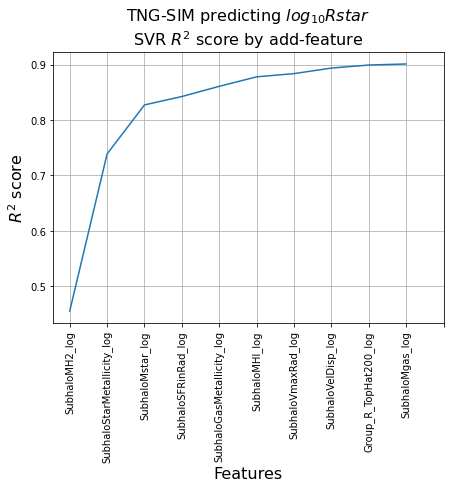

In [171]:
X = X_all
y = y_all

# Add-feature Ranking Method
# Note: This step calls 4 funcitons: run_random_search_pipeline(X,y), calculate_r_score(column_names),
# print_results(max_col_names, max_col_rscores), calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)

column_names = X.columns


max_col_names = [] # 
max_col_rscores = []
orj_column_names = list(column_names)


# first loop - over all features  
for i in tqdm(range(1, len(orj_column_names)+1)):
#     max_col_names, max_col_rscores, orj_column_names, r_score_dict = calc_ith_iteration(X, y, max_col_names, max_col_rscores, orj_column_names, i)
    
    
    # second loop, using i selected features + each of the remaining features individually
    r_score_dict = {} # to store r_squares from second loop
    
    for column_name in tqdm(orj_column_names,miniters = 6,colour = 'red', leave = None): 
        
        feature_list = max_col_names + [column_name]

        r_square = run_svr_search_pipeline(X[feature_list], y)
        r_score_dict[column_name] = r_square['mean_test_score'].max()
    
    max_col_names.append(max(r_score_dict, key=r_score_dict.get))
    max_col_rscores.append(max(r_score_dict.values()))

    
    orj_column_names.remove(max_col_names[len(max_col_names) - 1])
    
    print_results(max_col_names, max_col_rscores)
    
    if i==10: break # stop at 10th most important feature as I have observed that usually after the 7th feature R2 stabilizes

df_max_r_scores = pd.DataFrame({
    'feature_number' : range(1,11),
    'features':max_col_names,
    'r_sq_score': max_col_rscores  })
# Save the important feature ranking obtained by add-column method
#df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                    legend=False, grid=True, 
                    xticks=range(0,11))
fig_add_feature.set_title(label= r'TNG-SIM predicting $log_{10}Rstar$' + '\n' + 'SVR $R^{2}$ score by add-feature',fontsize=16)
fig_add_feature.set_xlabel('Features',fontsize=16)
fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)

In [173]:
# fig_add_feature.get_figure().savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_SVR_R_score_by_add_feature.jpg', dpi=500)


In [172]:
# df_max_r_scores.to_csv('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_SVR_Max r scores by add column method.csv', index=False)


	 1 SubhaloMH2_log 0.45545596118674103
	 2 SubhaloStarMetallicity_log 0.7388152565443943
	 3 SubhaloMstar_log 0.8271973364304738
	 4 SubhaloSFRinRad_log 0.8423750229236354
	 5 SubhaloGasMetallicity_log 0.8607383576525747
	 6 SubhaloMHI_log 0.8778516442251129
	 7 SubhaloVmaxRad_log 0.8836859044345285
	 8 SubhaloVelDisp_log 0.8936541912329657
	 9 Group_R_TopHat200_log 0.899164166767006
	 10 SubhaloMgas_log 0.9010560054399903

In [ ]:
def target_predicting_SVR_function(X, y, params = {}):
    
     # Add-feature Ranking Method
    # Note: This step calls 4 funcitons: run_random_search_pipeline(X,y), calculate_r_score(column_names),
    # print_results(max_col_names, max_col_rscores), calc_ith_iteration(max_col_names, max_col_rscores, orj_column_names, i)

    column_names = X.columns
        
    # init
    
    max_col_names = [] # 
    max_col_rscores = []
    orj_column_names = list(X.columns)


    # main 
    for i in range(1, len(orj_column_names)+1):
        max_col_names, max_col_rscores, orj_column_names, r_score_dict = calc_ith_iteration(X, y, max_col_names, max_col_rscores, orj_column_names, i)

        print(f"{i}. iteration: ")
        print_results(max_col_names, max_col_rscores)
        if i==10: break # stop at 10th most important feature as I have observed that usually after the 7th feature R2 stabilizes

    df_max_r_scores = pd.DataFrame({
        'feature_number' : range(1,11),
        'features':max_col_names,
        'r_sq_score': max_col_rscores  })
    # Save the important feature ranking obtained by add-column method
    #df_max_r_scores.to_csv('Max r scores by add column method.csv', index=False)

    fig_add_feature=df_max_r_scores.plot(x='features', y='r_sq_score', rot=90, figsize=(7,5), use_index=True,
                        legend=False, grid=True, 
                        xticks=range(0,11))
    fig_add_feature.set_title(label= r'TNG-SIM predicting $log_{10}Rstar$' + '\n' + 'SVR $R^{2}$ score by add-feature',fontsize=16)
    fig_add_feature.set_xlabel('Features',fontsize=16)
    fig_add_feature.set_ylabel(r'$R^{2}$ score',fontsize=16)
    
#     fig_add_feature.get_figure().savefig('R score by add-feature method.jpg', dpi=500)

    return df_max_r_scores, fig_add_feature


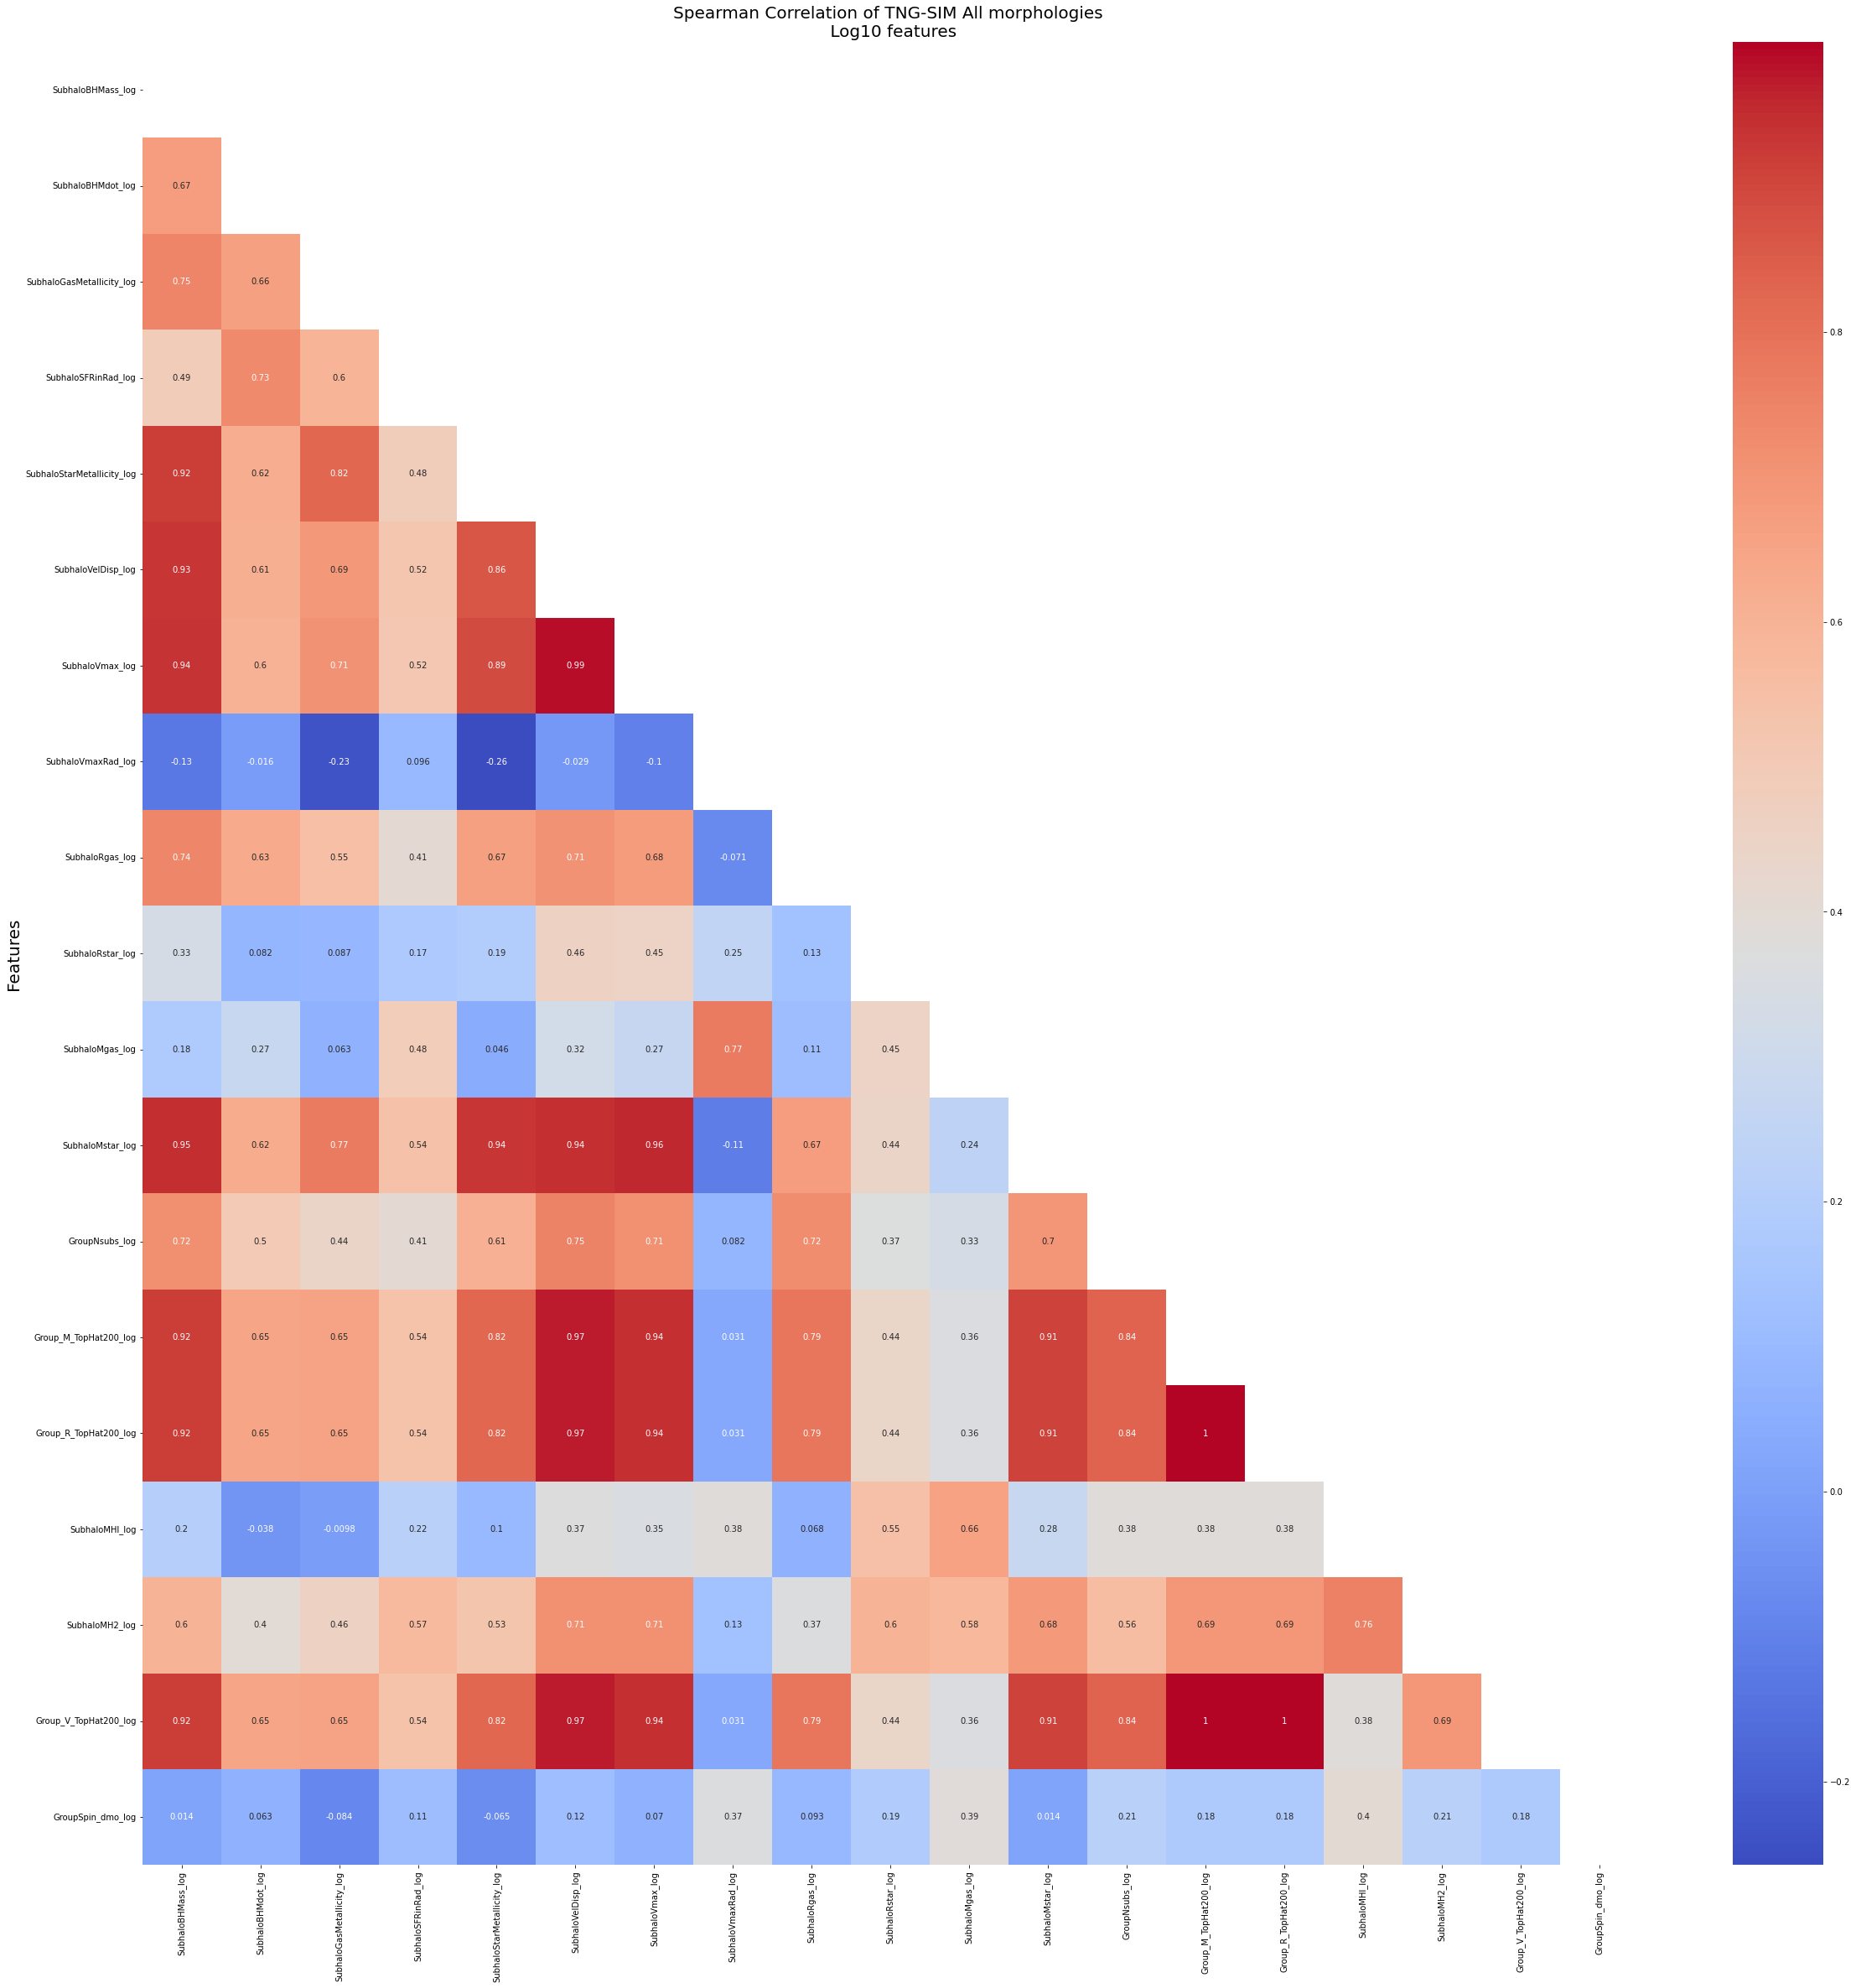

In [87]:
corr_df = df_raw_log.corr('spearman')
# corr_df = corr_df.sort_values('GalpropHalfRradius') # this is not a matrix where diagonal is 1 anymore; it only arranges half rad values from smallest to biggest
plt.figure(figsize=(40,40))
matrix = np.triu(corr_df) # take upper correlation matrix
sns.heatmap(corr_df, cmap="coolwarm",annot=True, mask=matrix)
plt.title("Spearman Correlation of TNG-SIM All morphologies \n Log10 features", fontsize = 20)
plt.ylabel("Features", fontsize = 20)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_TNG-SIM_Spearman_correlation_matrix_Allmorph_log.jpeg', dpi=500)
plt.show()

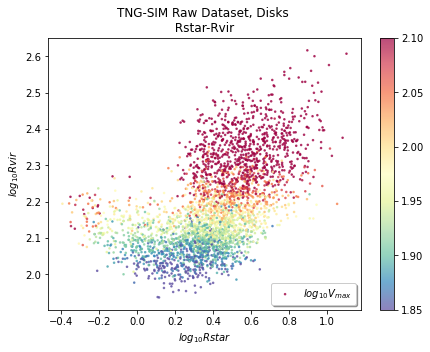

In [80]:
# Plot log10 Raw Rstar vs log 10 Raw Rvir

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks.SubhaloRstar_log, df_disks.Group_R_TopHat200_log,
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
# ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.91' + '\n' + r'Test $R^{2}_{logRstar}$=0.89' + '\n' + r'$MAPE_{logRstar}$=226$\%$ ', size=12)
# ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'Rstar-Rvir ')
ax.set_xlabel(r'$log_{10}Rstar$')
ax.set_ylabel(r'$log_{10}Rvir$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_RstarRvir_colorlogVmax.jpeg', dpi=500)
plt.show()

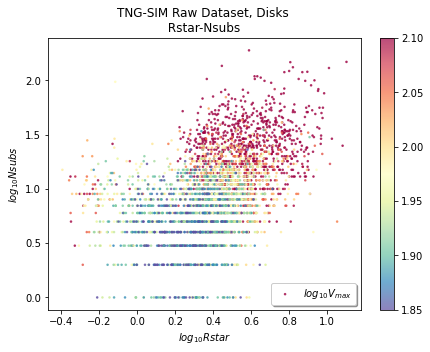

In [83]:
# Plot of Predicted log10 Raw Rstar vs True log 10 Raw Rstar

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks.SubhaloRstar_log, df_disks.GroupNsubs_log,
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
# ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.91' + '\n' + r'Test $R^{2}_{logRstar}$=0.89' + '\n' + r'$MAPE_{logRstar}$=226$\%$ ', size=12)
# ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'Rstar-Nsubs ')
ax.set_xlabel(r'$log_{10}Rstar$')
ax.set_ylabel(r'$log_{10}Nsubs$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_RstarNsubs_colorlogVmax.jpeg', dpi=500)
plt.show()

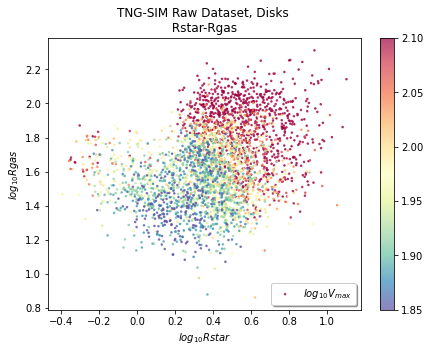

In [84]:
# Plot log10 Raw Rstar vs log 10 Raw Rvir

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks.SubhaloRstar_log, df_disks.SubhaloRgas_log,
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
# ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.91' + '\n' + r'Test $R^{2}_{logRstar}$=0.89' + '\n' + r'$MAPE_{logRstar}$=226$\%$ ', size=12)
# ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'Rstar-Rgas ')
ax.set_xlabel(r'$log_{10}Rstar$')
ax.set_ylabel(r'$log_{10}Rgas$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_RstarRgas_colorlogVmax.jpeg', dpi=500)
plt.show()

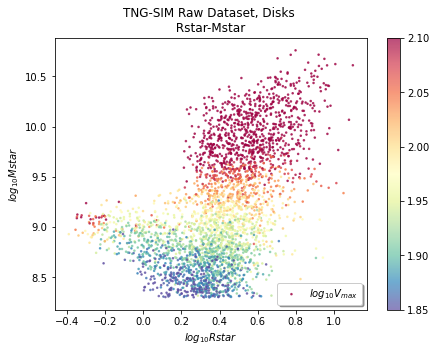

In [86]:
# Plot log10 Raw Rstar vs log 10 Raw Rvir

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(df_disks.SubhaloRstar_log, df_disks.SubhaloMstar_log,
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
# ax.text(-0.15, 1.1, r'Train $R^{2}_{logRstar}$=0.91' + '\n' + r'Test $R^{2}_{logRstar}$=0.89' + '\n' + r'$MAPE_{logRstar}$=226$\%$ ', size=12)
# ax.axis([-0.25,1.5, -0.25,1.5])
# ax.plot([-1.0, 2.0], [-1.0, 2.0], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'Rstar-Mstar ')
ax.set_xlabel(r'$log_{10}Rstar$')
ax.set_ylabel(r'$log_{10}Mstar$')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_RstarMstar_colorlogVmax.jpeg', dpi=500)
plt.show()

### Run the model w only the most important feature from above

In [91]:
df_disks.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['SubhaloBHMass_log', 'SubhaloBHMdot_log', 'SubhaloGasMetallicity_log',
       'SubhaloSFRinRad_log', 'SubhaloStarMetallicity_log',
       'SubhaloVelDisp_log', 'SubhaloVmax_log', 'SubhaloVmaxRad_log',
       'SubhaloRgas_log', 'SubhaloRstar_log', 'SubhaloMgas_log',
       'SubhaloMstar_log', 'GroupNsubs_log', 'Group_M_TopHat200_log',
       'Group_R_TopHat200_log', 'SubhaloMHI_log', 'SubhaloMH2_log',
       'Group_V_TopHat200_log', 'GroupSpin_dmo_log'],
      dtype='object')>

In [117]:
# drop all columns of dataset but Rvir
X_one = df_disks.drop(columns=['SubhaloBHMass_log', 'SubhaloBHMdot_log', 'SubhaloGasMetallicity_log',
       'SubhaloSFRinRad_log', 'SubhaloStarMetallicity_log',
       'SubhaloVelDisp_log', 'SubhaloVmax_log', 'SubhaloVmaxRad_log',
        'SubhaloRstar_log', 
       'SubhaloMstar_log',  'Group_M_TopHat200_log',
       'Group_R_TopHat200_log',
         'SubhaloRgas_log',                      
          'GroupNsubs_log',
#            'SubhaloMgas_log',                    
                               'SubhaloMHI_log', 'SubhaloMH2_log',
       'Group_V_TopHat200_log', 'GroupSpin_dmo_log'])
 

y_one = df_disks.loc[:,'SubhaloRstar_log']

In [118]:
X_one.shape

(3215, 1)

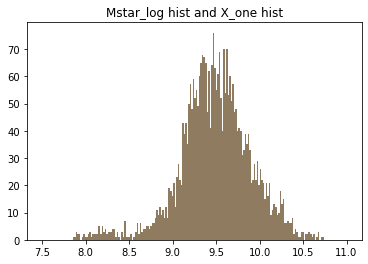

In [127]:
plt.hist(X_one, bins=200, range=(7.5, 11))
plt.hist(df_disks.SubhaloMgas_log, bins=200, alpha=0.5, range=(7.5, 11))
plt.title('Mstar_log hist and X_one hist')
plt.show()

In [119]:
# this code takes ~ ...min to run it on the complete TNG-SIM dataset with ~22,000 galaxies 

start_time = time.time()

piped_model = make_pipeline(StandardScaler(), SVR()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

#optimizing SVR

parameters = {'svr__kernel':['rbf'], \
              'svr__gamma':['scale', 0.01, 1.0, 10, 100], 
              'svr__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svr__epsilon':[0.05,0.1,0.2], 
             }


model_one = GridSearchCV(piped_model, parameters, cv = KFold(n_splits=3, shuffle=True), \
                     verbose = 2, n_jobs = -1, return_train_score=True)

model_one.fit(X_one, y_one)

print('Best params, best score:', "{:.4f}".format(model_one.best_score_), \
      model_one.best_params_)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR results on TNG-SIM Raw SVR Dataset: {elapsed_time:.3f} seconds")

Fitting 3 folds for each of 75 candidates, totalling 225 fits
Best params, best score: 0.3783 {'svr__C': 1000, 'svr__epsilon': 0.2, 'svr__gamma': 1.0, 'svr__kernel': 'rbf'}
Elapsed time to compute the SVR results on TNG-SIM Raw SVR Dataset: 13.092 seconds


In [120]:
start_time = time.time()

best_SVR_one=model_one.best_estimator_

best_SVR_trainscore_one=model_one.cv_results_['mean_train_score'][model_one.best_index_]

scores_SVR_one = cross_val_score(best_SVR_one, X_one, y_one, cv = KFold(n_splits=5, shuffle=True, random_state=10)) # cv score in all data?

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute this patch of code: {elapsed_time:.3f} seconds")

# It took 53 seconds ~ 1min to run this patch of code

Elapsed time to compute this patch of code: 1.249 seconds


In [121]:
start_time = time.time()

y_pred_SVR_one = cross_val_predict(best_SVR_one, X_one, y_one, cv = KFold(n_splits=5, shuffle=True, random_state=10))

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Disks Raw Dataset: {elapsed_time:.3f} seconds")

# It took 54 seconds ~ 1min to run this patch of code

Elapsed time to compute the SVR y_pred with cv=5 and optimal model from above, on Disks Raw Dataset: 1.253 seconds


In [122]:
y_pred_SVR_df_one = pd.DataFrame({'y_pred_SVR SIM Raw one': y_pred_SVR_one})

# y_pred_SVR_df_all.to_csv('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_y_pred_SVR_predicted_sizes.csv', index=False)

# y_pred_SVR_all = pd.read_csv('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_y_pred_SVR_predicted_sizes.csv')

In [123]:
best_SVR_trainscore_one

0.3863411092591879

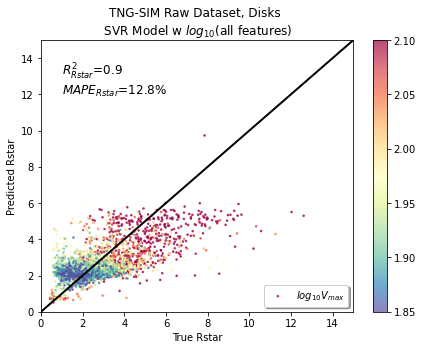

[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=0.01, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=100, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=0.01, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.2, svr__gamma=1.0, svr__kernel=rbf; total t

[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=10, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=0.01, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=10, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1000, svr__epsilon=0.1, svr__gamma=100, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1000, svr__epsilon=0.2, svr__gamma=scale, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1000, svr__epsilon=0.2, svr__gamma=1.0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf; total time=   0.2s
[CV] END svr__C=0.1, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf; total time=   0.2s
[CV] END svr__C=0.1, svr__epsilon=0.1, svr__gamma=1.0, svr__kernel=rbf; total ti

[CV] END svr__C=10.0, svr__epsilon=0.2, svr__gamma=1.0, svr__kernel=rbf; total time=   0.1s
[CV] END svr__C=10.0, svr__epsilon=0.2, svr__gamma=100, svr__kernel=rbf; total time=   0.1s
[CV] END svr__C=100.0, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf; total time=   0.2s
[CV] END svr__C=100.0, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf; total time=   0.7s
[CV] END svr__C=100.0, svr__epsilon=0.1, svr__gamma=100, svr__kernel=rbf; total time=   0.4s
[CV] END svr__C=100.0, svr__epsilon=0.2, svr__gamma=100, svr__kernel=rbf; total time=   0.3s
[CV] END svr__C=1000, svr__epsilon=0.05, svr__gamma=1.0, svr__kernel=rbf; total time=   0.6s
[CV] END svr__C=1000, svr__epsilon=0.05, svr__gamma=100, svr__kernel=rbf; total time=   3.1s
[CV] END svr__C=1000, svr__epsilon=0.1, svr__gamma=100, svr__kernel=rbf; total time=   2.7s


In [124]:
# Plot of Predicted Raw Rstar vs Raw Rstar 

fig_complete, ax = plt.subplots(figsize=(7, 5))

fig_SR = ax.scatter(10**(df_disks.SubhaloRstar_log), 10**(y_pred_SVR_one),
            c = df_disks.SubhaloVmax_log, 
            cmap='Spectral_r',
            s=10, marker='.', alpha=0.7,label= r'$log_{10}V_{max}$', vmin=1.85, vmax=2.1)
ax.text(1.0, 12, r'$R^{2}_{Rstar}$=0.9' + '\n' + r'$MAPE_{Rstar}$=12.8$\%$ ', size=12)
ax.axis([0.0,15, 0.0,15])
ax.plot([0, 30], [0, 30], color = 'black', linewidth = 2)
ax.set_title('TNG-SIM Raw Dataset, Disks \n ' + r'SVR Model w $log_{10}$(all features) ')
ax.set_xlabel(r'True Rstar')
ax.set_ylabel(r'Predicted Rstar')
ax.legend(loc = 'lower right', shadow=True)
fig_complete.colorbar(fig_SR, ax=ax)
# plt.savefig('TNG-SIM_images/v22_Disks_SVR/v22_Disks_TNG-SIM_Raw_SVR_size_pred_colorVmaxVvir_2.jpeg', dpi=500)
plt.show()